In [91]:
!pip install optuna


[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: C:\Users\rosac\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [92]:
!pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: C:\Users\rosac\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


## 학습용 데이터 로딩

In [84]:
train_audio_path = 'train'  
train_label_path = 'train_label.txt'  

In [93]:
import librosa
import matplotlib
import numpy as np
import sklearn
import tensorflow as tf
import ipykernel
print("librosa version:", librosa.__version__)
print("matplotlib version:", matplotlib.__version__)
print("numpy version:", np.__version__)
print("scikit-learn version:", sklearn.__version__)
print("tensorflow version:", tf.__version__)


librosa version: 0.11.0
matplotlib version: 3.9.4
numpy version: 2.0.2
scikit-learn version: 1.6.1
tensorflow version: 2.19.0


### 캐시가 없을 때
- 캐시가 있다면 목차의 "캐시로부터 MFCC 데이터 로드 함수"를 실행하고 난후 다음 단계로 넘어가주시기 바랍니다.

In [32]:
max_len = 4000
X, y = load_mfcc_data(train_audio_path, train_label_path, max_len)
X, scaler = standardize(X)

Loading MFCC: 100%|████████████████████████████████████████████████████████████████| 4000/4000 [02:09<00:00, 30.99it/s]


In [33]:
test_audio_path = 'test'
test_label_path = 'test_label.txt'

### 캐시가 없을 때
- 캐시가 있다면 목차의 "캐시로부터 MFCC 데이터 로드 함수"를 실행하고 난후 다음 단계로 넘어가주시기 바랍니다.
- 캐시를 생성하고 싶다면 목차의 "데이터 셋 캐시 저장"을 실행하시기 바립니다.

In [34]:
max_len = 2000

In [35]:
X_test, y_test = load_mfcc_data(test_audio_path, test_label_path, max_len)

ns_test = X_test.shape[0]
X_test, _ = standardize(X_test)

Loading MFCC: 100%|████████████████████████████████████████████████████████████████| 2000/2000 [00:38<00:00, 51.29it/s]


### 데이터 셋 캐시 저장
- 사용 예시
save_mfcc_cache(X, y, scaler, cache_prefix="train")
- 사용 조건
  - 목차의 "캐시가 없을 때"를 실행하고 난 후 실행하셔야 합니다.

#### Train set 캐시 저장 함수
- test set을 위한 코드가 아닙니다. train set에만 사용하시기 바랍니다.

In [95]:
# ──────────── 예시 셀 A ──────────── #
import os
import numpy as np
from sklearn.preprocessing import StandardScaler

def save_mfcc_cache_train(X, y, scaler, directory="cache/train"):
    os.makedirs(directory, exist_ok=True)
    X_path      = os.path.join(directory, "X.npy")
    y_path      = os.path.join(directory, "y.npy")
    scaler_path = os.path.join(directory, "scaler.npy")

    np.save(X_path, X)
    np.save(y_path, y)
    np.save(scaler_path, {'mean': scaler.mean_, 'scale': scaler.scale_})
    print("✅ 학습용 캐시 저장 완료:")
    print(f"   - X      → {X_path}")
    print(f"   - y      → {y_path}")
    print(f"   - scaler → {scaler_path}")
# 이 셀을 실행하면 “함수만 정의”되고 출력(프린트)은 없음.
# ──────────── 셀 A 끝 ──────────── #

# ──────────── 예시 셀 B ──────────── #
# 위에서 이미 정의한 save_mfcc_cache_train 함수를 "실제로 호출"하는 부분
save_mfcc_cache_train(X, y, scaler, directory="cache/train")


✅ 학습용 캐시 저장 완료:
   - X      → cache/train\X.npy
   - y      → cache/train\y.npy
   - scaler → cache/train\scaler.npy


#### Test set 캐시 저장
-  test set을 위한 코드입니다.

In [96]:
os.makedirs("cache/test", exist_ok=True)
test_X_path = "cache/test/X.npy"
test_y_path = "cache/test/y.npy"

np.save(test_X_path, X_test)
np.save(test_y_path, y_test)
print("✅ 테스트셋 캐시 저장 완료")


✅ 테스트셋 캐시 저장 완료


### 캐시로부터 MFCC 데이터 로드 함수
- 사용 예시
X, y, scaler = load_mfcc_cache(cache_prefix="train")
- 사용 조건
  - 이후 캐시를 저장하고 난 후는 계속해서 MFCC 데이터 로드 함수를 활용해 이후, 로드할 필요 없이 사용하시면 됩니다.

#### Train set 캐시 로드 함수

In [97]:
def load_mfcc_cache_train(directory="cache/train"):
    """
    설명:
      - "cache/train/" 폴더 아래에 저장된 X.npy, y.npy, scaler.npy 세 파일을 불러와,
        표준화된 학습용 데이터 X, 레이블 y, 그리고 복원된 StandardScaler 객체를 반환합니다.
      - 파일이 없으면 FileNotFoundError을 발생시킵니다.

    매개변수:
      directory : str, 캐시가 저장된 학습용 디렉터리 경로 (예: "cache/train")

    반환값:
      X      : np.ndarray, 학습용 입력 데이터
      y      : np.ndarray, 학습용 레이블
      scaler : sklearn.preprocessing.StandardScaler, 복원된 표준화 객체
    """
    # 1. 파일 경로 구성
    X_path      = os.path.join(directory, "X.npy")
    y_path      = os.path.join(directory, "y.npy")
    scaler_path = os.path.join(directory, "scaler.npy")

    # 2. 파일 존재 여부 검사
    if not (os.path.exists(X_path) and os.path.exists(y_path) and os.path.exists(scaler_path)):
        raise FileNotFoundError(f"❌ 학습용 캐시 파일이 존재하지 않습니다: {directory}")

    # 3. .npy 파일에서 데이터 로드
    X = np.load(X_path)
    y = np.load(y_path)
    scaler_params = np.load(scaler_path, allow_pickle=True).item()

    # 4. StandardScaler 객체로 복원
    scaler = StandardScaler()
    scaler.mean_  = scaler_params['mean']
    scaler.scale_ = scaler_params['scale']

    print(f"✅ 학습용 캐시 불러오기 완료: {directory}")
    return X, y, scaler


#### test set 캐시 로드

In [98]:
def load_mfcc_cache_test(directory="cache/test"):
    """
    설명:
      - "cache/test/" 폴더 아래에 저장된 X.npy, y.npy 두 파일을 불러와
        테스트용 입력 X_test와 레이블 y_test를 반환합니다.
      - 파일이 없으면 FileNotFoundError을 발생시킵니다.

    매개변수:
      directory : str, 캐시가 저장된 테스트용 디렉터리 경로 (예: "cache/test")

    반환값:
      X_test : np.ndarray, 테스트용 입력 데이터
      y_test : np.ndarray, 테스트용 레이블
    """
    # 1. 파일 경로 구성
    X_path = os.path.join(directory, "X.npy")
    y_path = os.path.join(directory, "y.npy")

    # 2. 파일 존재 여부 검사
    if not (os.path.exists(X_path) and os.path.exists(y_path)):
        raise FileNotFoundError(f"❌ 테스트용 캐시 파일이 존재하지 않습니다: {directory}")

    # 3. .npy 파일에서 데이터 로드
    X_test = np.load(X_path)
    y_test = np.load(y_path)

    print(f"✅ 테스트용 캐시 불러오기 완료: {directory}")
    return X_test, y_test




## 1. 필요 라이브러러 임포트 및 다운로드

In [99]:
# -------------------------------------------
# 1. 라이브러리 설치 및 임포트
# -------------------------------------------
import os
import random
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import BinaryCrossentropy

# 재현성 설정
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


## 데이터 로딩 함수 정의

In [100]:
# -------------------------------------------
# 2. 데이터 로딩 함수 정의
# -------------------------------------------
def load_mfcc_data(audio_path, label_path, max_len=200):
    entries = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                entries.append((parts[1], parts[-1]))
    df = pd.DataFrame(entries, columns=['filename','label'])

    X_list, y_list = [], []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Loading MFCC"):
        fp = os.path.join(audio_path, row['filename'])
        if not os.path.isfile(fp):
            continue
        try:
            audio, sr = librosa.load(fp, sr=16000)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20).T # 기존에는 13이었음.
            if mfcc.shape[0] < max_len:
                mfcc = np.pad(mfcc, ((0, max_len-mfcc.shape[0]), (0,0)), mode='constant')
            else:
                mfcc = mfcc[:max_len]
            X_list.append(mfcc)
            y_list.append(0 if row['label']=='Real' else 1)
        except:
            continue

    return np.array(X_list), np.array(y_list)


def standardize(X):
    ns, nt, nf = X.shape
    scaler = StandardScaler().fit(X.reshape(-1, nf))
    X_scaled = scaler.transform(X.reshape(-1, nf)).reshape(ns, nt, nf)
    return X_scaled, scaler


## DNN 모델 정의

In [101]:
def build_dnn_model(
    input_shape,
    units1=128,         # 첫 번째 Dense 레이어의 유닛 수 (튜닝 대상)
    units2=64,          # 두 번째 Dense 레이어의 유닛 수 (튜닝 대상)
    dropout1=0.3,       # 첫 번째 Dropout 비율 (튜닝 대상)
    dropout2=0.3,       # 두 번째 Dropout 비율 (튜닝 대상)
    learning_rate=1e-3  # Adam 학습률 (튜닝 대상)
):
    """
    기존 모델 정의 부분을 하이퍼파라미터 인자를 받도록 수정한 함수입니다.
      - units1, units2: 각 Dense 레이어의 유닛 개수
      - dropout1, dropout2: 각 Dropout 레이어 비율
      - learning_rate: Adam 옵티마이저 학습률
    """
    model = models.Sequential([
        layers.Input(shape=input_shape, name="input_mfcc"),
        layers.Flatten(name="flatten"),

        # 첫 번째 Dense 블록
        layers.Dense(units1, activation=None, name="dense_1"),
        layers.BatchNormalization(name="bn_1"),
        layers.Activation('relu', name="act_1"),
        layers.Dropout(dropout1, name="dropout_1"),

        # 두 번째 Dense 블록
        layers.Dense(units2, activation=None, name="dense_2"),
        layers.BatchNormalization(name="bn_2"),
        layers.Activation('relu', name="act_2"),
        layers.Dropout(dropout2, name="dropout_2"),

        # 출력층
        layers.Dense(1, activation='sigmoid', name="output")
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [102]:
import optuna
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt  # 시각화를 위해 matplotlib 가져오기


# === 2) objective 함수 정의 ===
def objective(trial):
    # 2-1) 튜닝할 하이퍼파라미터 샘플링
    units1 = trial.suggest_categorical("units1", [64, 96, 128, 192, 256, 384, 512])
    units2 = trial.suggest_categorical("units2", [32, 64, 128, 256])
    dropout1 = trial.suggest_float("dropout1", 0.1, 0.5, step=0.1)
    dropout2 = trial.suggest_float("dropout2", 0.1, 0.5, step=0.1)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # 2-2) 학습/검증용 데이터 분리
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=41
    )

    # 2-3) 클래스 가중치 계산 (필요 시)
    class_weights_array = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = {cls: w for cls, w in zip(np.unique(y_train), class_weights_array)}

    # 2-4) 모델 생성 (항상 2개 블록)
    input_shape = X_train.shape[1:]
    model = build_dnn_model(
        input_shape=input_shape,
        units1=units1,
        units2=units2,
        dropout1=dropout1,
        dropout2=dropout2,
        learning_rate=learning_rate
    )

    # 2-5) 콜백 정의
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]

    # 2-6) 모델 학습
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=batch_size,
        class_weight=class_weight_dict,
        callbacks=callbacks,
        verbose=0
    )

    # 2-7) 마지막 에폭의 검증 정확도 반환
    val_acc = history.history["val_accuracy"][-1]
    print(f"[Trial {trial.number:>2d}] "
          f"units1={units1}, units2={units2}, "
          f"dropout1={dropout1:.1f}, dropout2={dropout2:.1f}, "
          f"lr={learning_rate:.1e}, batch_size={batch_size} → val_acc={val_acc:.4f}\n")
    return val_acc

[I 2025-06-04 23:09:16,649] A new study created in memory with name: no-name-f84695ab-d65b-424e-97db-5c8aacd4b066
Best trial: 0. Best value: 0.99:   3%|█▋                                                | 1/30 [01:27<42:31, 87.97s/it]

[Trial  0] units1=128, units2=32, dropout1=0.5, dropout2=0.2, lr=2.0e-03, batch_size=32 → val_acc=0.9900

[I 2025-06-04 23:10:44,722] Trial 0 finished with value: 0.9900000095367432 and parameters: {'units1': 128, 'units2': 32, 'dropout1': 0.5, 'dropout2': 0.2, 'learning_rate': 0.00200542189906824, 'batch_size': 32}. Best is trial 0 with value: 0.9900000095367432.


Best trial: 1. Best value: 0.9925:   7%|███▏                                            | 2/30 [02:59<41:53, 89.77s/it]

[Trial  1] units1=128, units2=64, dropout1=0.3, dropout2=0.2, lr=9.0e-03, batch_size=16 → val_acc=0.9925

[I 2025-06-04 23:12:15,755] Trial 1 finished with value: 0.9925000071525574 and parameters: {'units1': 128, 'units2': 64, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'learning_rate': 0.008986401535704366, 'batch_size': 16}. Best is trial 1 with value: 0.9925000071525574.


Best trial: 1. Best value: 0.9925:  10%|████▊                                           | 3/30 [03:46<31:47, 70.63s/it]

[Trial  2] units1=64, units2=256, dropout1=0.4, dropout2=0.1, lr=1.8e-04, batch_size=64 → val_acc=0.9925

[I 2025-06-04 23:13:03,612] Trial 2 finished with value: 0.9925000071525574 and parameters: {'units1': 64, 'units2': 256, 'dropout1': 0.4, 'dropout2': 0.1, 'learning_rate': 0.00018337341530797754, 'batch_size': 64}. Best is trial 1 with value: 0.9925000071525574.


Best trial: 1. Best value: 0.9925:  13%|██████▎                                        | 4/30 [06:43<48:44, 112.47s/it]

[Trial  3] units1=256, units2=32, dropout1=0.4, dropout2=0.3, lr=2.2e-03, batch_size=16 → val_acc=0.9925

[I 2025-06-04 23:16:00,216] Trial 3 finished with value: 0.9925000071525574 and parameters: {'units1': 256, 'units2': 32, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'learning_rate': 0.002168224787366759, 'batch_size': 16}. Best is trial 1 with value: 0.9925000071525574.


Best trial: 4. Best value: 0.99375:  17%|███████▋                                      | 5/30 [08:46<48:24, 116.18s/it]

[Trial  4] units1=256, units2=128, dropout1=0.1, dropout2=0.5, lr=2.1e-04, batch_size=64 → val_acc=0.9937

[I 2025-06-04 23:18:02,971] Trial 4 finished with value: 0.9937499761581421 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.5, 'learning_rate': 0.00021474538817864447, 'batch_size': 64}. Best is trial 4 with value: 0.9937499761581421.


Best trial: 4. Best value: 0.99375:  20%|█████████▏                                    | 6/30 [11:50<55:47, 139.47s/it]

[Trial  5] units1=384, units2=128, dropout1=0.1, dropout2=0.3, lr=1.7e-03, batch_size=32 → val_acc=0.9925

[I 2025-06-04 23:21:07,650] Trial 5 finished with value: 0.9925000071525574 and parameters: {'units1': 384, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0017096169725210279, 'batch_size': 32}. Best is trial 4 with value: 0.9937499761581421.


Best trial: 4. Best value: 0.99375:  23%|██████████▋                                   | 7/30 [14:38<56:57, 148.59s/it]

[Trial  6] units1=384, units2=32, dropout1=0.2, dropout2=0.2, lr=5.8e-04, batch_size=64 → val_acc=0.9925

[I 2025-06-04 23:23:55,012] Trial 6 finished with value: 0.9925000071525574 and parameters: {'units1': 384, 'units2': 32, 'dropout1': 0.2, 'dropout2': 0.2, 'learning_rate': 0.0005761783629938512, 'batch_size': 64}. Best is trial 4 with value: 0.9937499761581421.


Best trial: 4. Best value: 0.99375:  27%|███████████▋                                | 8/30 [19:29<1:11:11, 194.14s/it]

[Trial  7] units1=512, units2=32, dropout1=0.2, dropout2=0.1, lr=5.1e-04, batch_size=32 → val_acc=0.9937

[I 2025-06-04 23:28:46,689] Trial 7 finished with value: 0.9937499761581421 and parameters: {'units1': 512, 'units2': 32, 'dropout1': 0.2, 'dropout2': 0.1, 'learning_rate': 0.0005140245634986926, 'batch_size': 32}. Best is trial 4 with value: 0.9937499761581421.


Best trial: 8. Best value: 0.995:  30%|██████████████▍                                 | 9/30 [20:49<55:21, 158.19s/it]

[Trial  8] units1=128, units2=128, dropout1=0.1, dropout2=0.3, lr=4.1e-03, batch_size=32 → val_acc=0.9950

[I 2025-06-04 23:30:05,826] Trial 8 finished with value: 0.9950000047683716 and parameters: {'units1': 128, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'learning_rate': 0.004077968727491807, 'batch_size': 32}. Best is trial 8 with value: 0.9950000047683716.


Best trial: 8. Best value: 0.995:  33%|███████████████                              | 10/30 [25:18<1:04:10, 192.53s/it]

[Trial  9] units1=384, units2=64, dropout1=0.4, dropout2=0.3, lr=4.2e-04, batch_size=16 → val_acc=0.9925

[I 2025-06-04 23:34:35,250] Trial 9 finished with value: 0.9925000071525574 and parameters: {'units1': 384, 'units2': 64, 'dropout1': 0.4, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0004208910318100536, 'batch_size': 16}. Best is trial 8 with value: 0.9950000047683716.


Best trial: 8. Best value: 0.995:  37%|█████████████████▏                             | 11/30 [26:34<49:41, 156.91s/it]

[Trial 10] units1=192, units2=128, dropout1=0.2, dropout2=0.5, lr=7.9e-03, batch_size=32 → val_acc=0.9900

[I 2025-06-04 23:35:51,390] Trial 10 finished with value: 0.9900000095367432 and parameters: {'units1': 192, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.5, 'learning_rate': 0.007904489581192373, 'batch_size': 32}. Best is trial 8 with value: 0.9950000047683716.


Best trial: 8. Best value: 0.995:  40%|██████████████████▊                            | 12/30 [27:45<39:14, 130.81s/it]

[Trial 11] units1=96, units2=128, dropout1=0.1, dropout2=0.5, lr=1.2e-04, batch_size=64 → val_acc=0.9937

[I 2025-06-04 23:37:02,506] Trial 11 finished with value: 0.9937499761581421 and parameters: {'units1': 96, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.5, 'learning_rate': 0.00012246791782617738, 'batch_size': 64}. Best is trial 8 with value: 0.9950000047683716.


Best trial: 8. Best value: 0.995:  43%|████████████████████▎                          | 13/30 [29:17<33:41, 118.93s/it]

[Trial 12] units1=256, units2=128, dropout1=0.1, dropout2=0.4, lr=4.5e-03, batch_size=64 → val_acc=0.9925

[I 2025-06-04 23:38:34,109] Trial 12 finished with value: 0.9925000071525574 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.4, 'learning_rate': 0.004450766921979733, 'batch_size': 64}. Best is trial 8 with value: 0.9950000047683716.


Best trial: 8. Best value: 0.995:  47%|█████████████████████▉                         | 14/30 [30:47<29:23, 110.25s/it]

[Trial 13] units1=256, units2=128, dropout1=0.1, dropout2=0.4, lr=2.4e-04, batch_size=64 → val_acc=0.9925

[I 2025-06-04 23:40:04,293] Trial 13 finished with value: 0.9925000071525574 and parameters: {'units1': 256, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.4, 'learning_rate': 0.00024354295012354963, 'batch_size': 64}. Best is trial 8 with value: 0.9950000047683716.


Best trial: 8. Best value: 0.995:  50%|████████████████████████                        | 15/30 [31:51<24:03, 96.23s/it]

[Trial 14] units1=128, units2=256, dropout1=0.2, dropout2=0.4, lr=1.0e-03, batch_size=32 → val_acc=0.9912

[I 2025-06-04 23:41:08,039] Trial 14 finished with value: 0.9912499785423279 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.4, 'learning_rate': 0.00102304968348859, 'batch_size': 32}. Best is trial 8 with value: 0.9950000047683716.


Best trial: 8. Best value: 0.995:  53%|█████████████████████████▌                      | 16/30 [32:46<19:33, 83.84s/it]

[Trial 15] units1=96, units2=128, dropout1=0.3, dropout2=0.5, lr=4.2e-03, batch_size=32 → val_acc=0.9925

[I 2025-06-04 23:42:03,119] Trial 15 finished with value: 0.9925000071525574 and parameters: {'units1': 96, 'units2': 128, 'dropout1': 0.30000000000000004, 'dropout2': 0.5, 'learning_rate': 0.004158061152982995, 'batch_size': 32}. Best is trial 8 with value: 0.9950000047683716.


Best trial: 8. Best value: 0.995:  57%|███████████████████████████▏                    | 17/30 [33:49<16:49, 77.64s/it]

[Trial 16] units1=192, units2=128, dropout1=0.1, dropout2=0.4, lr=9.2e-04, batch_size=64 → val_acc=0.9925

[I 2025-06-04 23:43:06,322] Trial 16 finished with value: 0.9925000071525574 and parameters: {'units1': 192, 'units2': 128, 'dropout1': 0.1, 'dropout2': 0.4, 'learning_rate': 0.0009221720767103872, 'batch_size': 64}. Best is trial 8 with value: 0.9950000047683716.


Best trial: 8. Best value: 0.995:  60%|████████████████████████████▊                   | 18/30 [34:51<14:34, 72.90s/it]

[Trial 17] units1=64, units2=128, dropout1=0.2, dropout2=0.5, lr=1.0e-04, batch_size=64 → val_acc=0.9937

[I 2025-06-04 23:44:08,199] Trial 17 finished with value: 0.9937499761581421 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.5, 'learning_rate': 0.00010152496009329404, 'batch_size': 64}. Best is trial 8 with value: 0.9950000047683716.


Best trial: 8. Best value: 0.995:  63%|██████████████████████████████▍                 | 19/30 [36:55<16:11, 88.32s/it]

[Trial 18] units1=256, units2=256, dropout1=0.3, dropout2=0.2, lr=2.8e-04, batch_size=32 → val_acc=0.9937

[I 2025-06-04 23:46:12,452] Trial 18 finished with value: 0.9937499761581421 and parameters: {'units1': 256, 'units2': 256, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'learning_rate': 0.0002834676860918393, 'batch_size': 32}. Best is trial 8 with value: 0.9950000047683716.


Best trial: 8. Best value: 0.995:  67%|███████████████████████████████▎               | 20/30 [43:23<29:42, 178.26s/it]

[Trial 19] units1=512, units2=64, dropout1=0.1, dropout2=0.4, lr=3.3e-03, batch_size=16 → val_acc=0.9925

[I 2025-06-04 23:52:40,313] Trial 19 finished with value: 0.9925000071525574 and parameters: {'units1': 512, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.4, 'learning_rate': 0.003253967459727722, 'batch_size': 16}. Best is trial 8 with value: 0.9950000047683716.


Best trial: 8. Best value: 0.995:  70%|████████████████████████████████▉              | 21/30 [44:06<20:39, 137.69s/it]

[Trial 20] units1=128, units2=128, dropout1=0.5, dropout2=0.3, lr=9.3e-04, batch_size=64 → val_acc=0.9925

[I 2025-06-04 23:53:23,428] Trial 20 finished with value: 0.9925000071525574 and parameters: {'units1': 128, 'units2': 128, 'dropout1': 0.5, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0009258902517497897, 'batch_size': 64}. Best is trial 8 with value: 0.9950000047683716.


Best trial: 8. Best value: 0.995:  73%|██████████████████████████████████▍            | 22/30 [49:13<25:06, 188.30s/it]

[Trial 21] units1=512, units2=32, dropout1=0.2, dropout2=0.1, lr=5.0e-04, batch_size=32 → val_acc=0.9937

[I 2025-06-04 23:58:29,761] Trial 21 finished with value: 0.9937499761581421 and parameters: {'units1': 512, 'units2': 32, 'dropout1': 0.2, 'dropout2': 0.1, 'learning_rate': 0.0004986504803365764, 'batch_size': 32}. Best is trial 8 with value: 0.9950000047683716.


Best trial: 8. Best value: 0.995:  77%|████████████████████████████████████           | 23/30 [53:51<25:08, 215.43s/it]

[Trial 22] units1=512, units2=32, dropout1=0.2, dropout2=0.1, lr=3.5e-04, batch_size=32 → val_acc=0.9925

[I 2025-06-05 00:03:08,457] Trial 22 finished with value: 0.9925000071525574 and parameters: {'units1': 512, 'units2': 32, 'dropout1': 0.2, 'dropout2': 0.1, 'learning_rate': 0.0003457559707429875, 'batch_size': 32}. Best is trial 8 with value: 0.9950000047683716.


Best trial: 8. Best value: 0.995:  80%|████████████████████████████████████         | 24/30 [1:01:25<28:41, 286.85s/it]

[Trial 23] units1=512, units2=32, dropout1=0.1, dropout2=0.2, lr=1.8e-04, batch_size=32 → val_acc=0.9937

[I 2025-06-05 00:10:41,909] Trial 23 finished with value: 0.9937499761581421 and parameters: {'units1': 512, 'units2': 32, 'dropout1': 0.1, 'dropout2': 0.2, 'learning_rate': 0.00017581055878558818, 'batch_size': 32}. Best is trial 8 with value: 0.9950000047683716.


Best trial: 8. Best value: 0.995:  83%|█████████████████████████████████████▌       | 25/30 [1:04:41<21:37, 259.59s/it]

[Trial 24] units1=512, units2=128, dropout1=0.2, dropout2=0.1, lr=5.4e-04, batch_size=32 → val_acc=0.9937

[I 2025-06-05 00:13:57,924] Trial 24 finished with value: 0.9937499761581421 and parameters: {'units1': 512, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.1, 'learning_rate': 0.0005417692750132729, 'batch_size': 32}. Best is trial 8 with value: 0.9950000047683716.


Best trial: 8. Best value: 0.995:  87%|███████████████████████████████████████      | 26/30 [1:06:50<14:41, 220.49s/it]

[Trial 25] units1=256, units2=32, dropout1=0.1, dropout2=0.3, lr=1.3e-03, batch_size=32 → val_acc=0.9925

[I 2025-06-05 00:16:07,193] Trial 25 finished with value: 0.9925000071525574 and parameters: {'units1': 256, 'units2': 32, 'dropout1': 0.1, 'dropout2': 0.30000000000000004, 'learning_rate': 0.0012897574371728184, 'batch_size': 32}. Best is trial 8 with value: 0.9950000047683716.


Best trial: 8. Best value: 0.995:  90%|████████████████████████████████████████▌    | 27/30 [1:08:01<08:46, 175.60s/it]

[Trial 26] units1=128, units2=256, dropout1=0.2, dropout2=0.4, lr=7.3e-04, batch_size=32 → val_acc=0.9912

[I 2025-06-05 00:17:18,056] Trial 26 finished with value: 0.9912499785423279 and parameters: {'units1': 128, 'units2': 256, 'dropout1': 0.2, 'dropout2': 0.4, 'learning_rate': 0.000725353483237914, 'batch_size': 32}. Best is trial 8 with value: 0.9950000047683716.


Best trial: 8. Best value: 0.995:  93%|██████████████████████████████████████████   | 28/30 [1:09:19<04:52, 146.34s/it]

[Trial 27] units1=96, units2=64, dropout1=0.1, dropout2=0.2, lr=1.9e-04, batch_size=32 → val_acc=0.9925

[I 2025-06-05 00:18:36,127] Trial 27 finished with value: 0.9925000071525574 and parameters: {'units1': 96, 'units2': 64, 'dropout1': 0.1, 'dropout2': 0.2, 'learning_rate': 0.00018603384266603021, 'batch_size': 32}. Best is trial 8 with value: 0.9950000047683716.


Best trial: 8. Best value: 0.995:  97%|███████████████████████████████████████████▌ | 29/30 [1:10:21<02:00, 120.99s/it]

[Trial 28] units1=64, units2=128, dropout1=0.2, dropout2=0.5, lr=6.3e-03, batch_size=16 → val_acc=0.9912

[I 2025-06-05 00:19:37,974] Trial 28 finished with value: 0.9912499785423279 and parameters: {'units1': 64, 'units2': 128, 'dropout1': 0.2, 'dropout2': 0.5, 'learning_rate': 0.006328451419757687, 'batch_size': 16}. Best is trial 8 with value: 0.9950000047683716.


Best trial: 8. Best value: 0.995: 100%|█████████████████████████████████████████████| 30/30 [1:11:08<00:00, 142.27s/it]

[Trial 29] units1=128, units2=32, dropout1=0.3, dropout2=0.2, lr=2.6e-03, batch_size=64 → val_acc=0.9937

[I 2025-06-05 00:20:24,821] Trial 29 finished with value: 0.9937499761581421 and parameters: {'units1': 128, 'units2': 32, 'dropout1': 0.30000000000000004, 'dropout2': 0.2, 'learning_rate': 0.0026143909991963553, 'batch_size': 64}. Best is trial 8 with value: 0.9950000047683716.
========== 최적 하이퍼파라미터 ==========
units1: 128
units2: 128
dropout1: 0.1
dropout2: 0.30000000000000004
learning_rate: 0.004077968727491807
batch_size: 32


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.9178 - loss: 0.2013 - val_accuracy: 0.8050 - val_loss: 0.7468 - learning_rate: 0.0041
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9964 - loss: 0.0197 - val_accuracy: 0.8637 - val_loss: 0.4787 - learning_rate: 0.0041
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9985 - loss: 0.0075 - val_accuracy: 0.8625 - val_loss: 0.4887 - learning_rate: 0.0041
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9983 - loss: 0.0052 - val_accuracy: 0.8725 - val_loss: 0.4813 - learning_rate: 0.0041
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9997 - loss: 0.0022 - val_accuracy: 0.8788 - val_loss: 0.5074 - learning_rate: 0.0041
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.8925 - val_loss: 0.3989 - learning_rate: 0.0041
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 1.0000 - loss: 9.

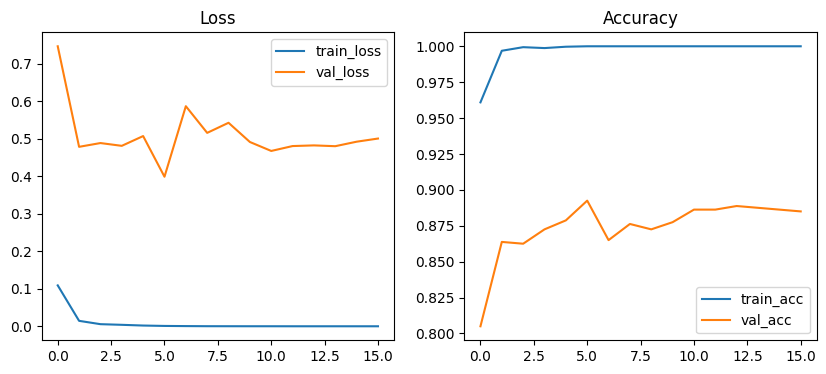

In [103]:
# ============================================
# 3) Optuna 스터디 생성 및 최적화 실행
# ============================================
if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30, show_progress_bar=True)

    print("========== 최적 하이퍼파라미터 ==========")
    for key, value in study.best_params.items():
        print(f"{key}: {value}")

    # ============================================
    # 4) 최적 파라미터로 전체 데이터 재학습
    # ============================================
    best = study.best_params
    final_model = build_dnn_model(
        input_shape=X.shape[1:],
        units1=best["units1"],
        units2=best["units2"],
        dropout1=best["dropout1"],
        dropout2=best["dropout2"],
        learning_rate=best["learning_rate"]
    )

    callbacks_final = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]

    # 4-1) 최종 학습 결과를 history 객체로 저장
    final_history = final_model.fit(
        X, y,
        validation_split=0.2,
        epochs=50,
        batch_size=best["batch_size"],
        class_weight={cls: w for cls, w in zip(np.unique(y), compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y),
            y=y
        ))},
        callbacks=callbacks_final,
        verbose=1
    )

    # ============================================
    # 5) 최종 학습 과정 시각화 (plot_history 함수 사용)
    # ============================================
    def plot_history(history):
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='train_loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.title("Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='train_acc')
        plt.plot(history.history['val_accuracy'], label='val_acc')
        plt.title("Accuracy")
        plt.legend()

        plt.show()

    # plot_history 함수를 호출하여 학습/검증 지표 시각화
    plot_history(final_history)

    # 5-2) 모델 저장
    final_model.save("dnn_model.h5")

In [104]:
# Optuna 튜닝 완료 후, 동일 best_value를 가진 Trial 중 최종 Best를 선택하는 후처리 코드

# 1) Optuna가 기록한 최고 검증 정확도 가져오기
best_value = study.best_value

# 2) 동일한 value를 가진 모든 Trial 리스트 생성
same_value_trials = [t for t in study.trials if t.value == best_value]

# 3) 모델 복잡도 계산 함수 (units1 * units2)
def model_complexity(trial):
    return trial.params.get("units1", float("inf")) * trial.params.get("units2", float("inf"))

# 4) 실행 시간 계산 함수
def trial_duration(trial):
    if trial.datetime_start and trial.datetime_complete:
        return (trial.datetime_complete - trial.datetime_start).total_seconds()
    return float("inf")

# 5) Tie-breaker: 1차 기준=모델 복잡도(작을수록 우선), 2차 기준=실행 시간(짧을수록 우선)
def tie_breaker_key(trial):
    return (model_complexity(trial), trial_duration(trial))

# 6) 정렬 후 최종 Best Trial 선택
sorted_trials = sorted(same_value_trials, key=tie_breaker_key)
final_best = sorted_trials[0]

# 7) 최종 Best 파라미터
best_params = final_best.params

# 예시 출력
print("========== 최종 Tie-breaker 적용 결과 ==========")
for key, value in best_params.items():
    print(f"{key}: {value}")


========== 최종 Tie-breaker 적용 결과 ==========
units1: 128
units2: 128
dropout1: 0.1
dropout2: 0.30000000000000004
learning_rate: 0.004077968727491807
batch_size: 32


# 테스트 데이터 로딩 및 평가

테스트 샘플별 원본 time_steps 길이 분포:
  길이=2000인 샘플 수: 2000

패딩 전후 shape 비교:
  샘플 1: 원본 (2000, 20) → 패딩 후 (4000, 20)
  샘플 2: 원본 (2000, 20) → 패딩 후 (4000, 20)
  샘플 3: 원본 (2000, 20) → 패딩 후 (4000, 20)
  샘플 4: 원본 (2000, 20) → 패딩 후 (4000, 20)
  샘플 5: 원본 (2000, 20) → 패딩 후 (4000, 20)

전체 패딩 후 X_test_padded.shape: (2000, 4000, 20)
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

✅ Classification Report - TEST DATA
              precision    recall  f1-score   support

        Real       0.84      0.99      0.91      1000
        Fake       0.99      0.81      0.89      1000

    accuracy                           0.90      2000
   macro avg       0.92      0.90      0.90      2000
weighted avg       0.92      0.90      0.90      2000

ROC AUC: 0.912


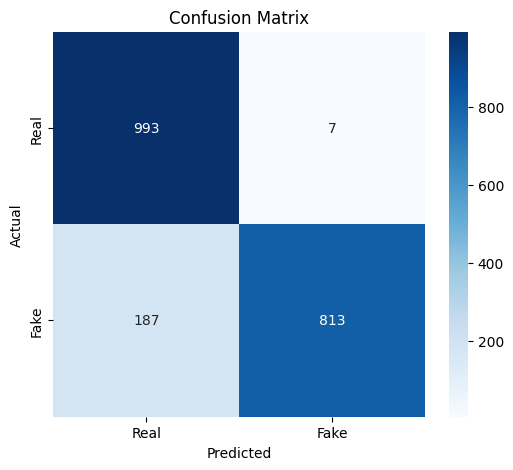

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# -------------------------------------------
# 6. 테스트 데이터 평가 (길이 확인 후 패딩 포함)
# -------------------------------------------

# (1) 패딩 대상 시퀀스 길이 확인
#    X_test.shape == (n_samples, time_steps, n_features) 일 때,
#    각 샘플의 time_steps (예: mfcc.shape[0])가 무엇인지 확인합니다.
time_steps_list = [sample.shape[0] for sample in X_test]
unique_lengths, counts = np.unique(time_steps_list, return_counts=True)
print("테스트 샘플별 원본 time_steps 길이 분포:")
for length, cnt in zip(unique_lengths, counts):
    print(f"  길이={length}인 샘플 수: {cnt}")
# 예) 길이=2000인 샘플 수: 2000
#     (모두 2000이라면 이 한 줄만 표시됩니다)

# (2) 패딩 함수 정의: (time_steps, n_features) → (4000, n_features)
def pad_to_4000(x: np.ndarray) -> np.ndarray:
    """
    x: np.ndarray of shape (time_steps, n_features)
    return: np.ndarray of shape (4000, n_features), 부족한 부분은 뒤에 0으로 채움
    """
    current_len, n_feat = x.shape
    if current_len >= 4000:
        # 길이가 4000 이상인 경우 앞쪽 4000 프레임만 사용
        return x[:4000, :]
    # 부족한 길이만큼 뒤쪽에 0으로 패딩
    pad_width = 4000 - current_len
    padding = np.zeros((pad_width, n_feat), dtype=x.dtype)
    return np.concatenate([x, padding], axis=0)

# (3) 패딩 적용 전/후 길이를 동시에 확인
print("\n패딩 전후 shape 비교:")
for idx, sample in enumerate(X_test[:5]):  # 첫 5개 샘플만 예시로 출력
    orig_shape = sample.shape
    padded = pad_to_4000(sample)
    print(f"  샘플 {idx+1}: 원본 {orig_shape} → 패딩 후 {padded.shape}")

# (4) 전체 테스트 세트에 패딩 적용
X_test_padded = np.array([pad_to_4000(sample) for sample in X_test])
#    이제 X_test_padded.shape == (n_samples, 4000, n_features) 이어야 합니다.
print(f"\n전체 패딩 후 X_test_padded.shape: {X_test_padded.shape}")
# 예시: (2000, 4000, 20)

# (5) 모델 예측 (Flatten은 모델 내부에서 자동 처리됨)
y_prob = model.predict(X_test_padded)  # shape: (n_samples, 1) 또는 (n_samples,)
y_pred = (y_prob > 0.8).astype(int).reshape(-1)

# (6) 평가 지표 출력
print("\n✅ Classification Report - TEST DATA")
print(classification_report(y_test, y_pred, target_names=['Real','Fake']))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.3f}")

# (7) 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
여기서 부터 오류남


## Spectral_Contrast 특징 활용 모델
- 오분류된 데이터에 대해서 따로 특징을 추출하여 분류를 시도함. 이를 활용하여 약 1% 성능 향상이 가능하였음.

In [106]:
import os
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm

def pad_to_4000(x: np.ndarray) -> np.ndarray:
    """
    x: np.ndarray of shape (time_steps, n_features)
    return: np.ndarray of shape (4000, n_features), 부족한 부분은 뒤에 0으로 채움
    """
    current_len, n_feat = x.shape
    if current_len >= 4000:
        # 길이가 4000 이상이면 앞쪽 4000프레임만 사용
        return x[:4000, :]
    pad_width = 4000 - current_len
    padding = np.zeros((pad_width, n_feat), dtype=x.dtype)
    return np.concatenate([x, padding], axis=0)

def predict_with_spectral_contrast(model, X_test, test_label_path, test_audio_path, score: float = 0.32):
    """
    1) X_test: np.ndarray of shape (n_samples, time_steps, n_features) — 패딩 전 상태일 수 있음
    2) test_label_path: 'test_label.txt' 파일 경로 (공백으로 구분된 두 번째 컬럼=filename, 다섯 번째 컬럼=label)
    3) test_audio_path: 테스트 오디오 파일들이 들어 있는 폴더 경로
    4) score: DNN 확률 임계값 (예: 0.32 이하인 샘플만 Spectral Contrast 보정 대상)
    
    반환:
      y_prob: np.ndarray of shape (n_samples,) — 보정된 확률 벡터
    """
    # 🔹 0. X_test 길이가 4000×n_features인지 확인하고, 아니면 패딩 적용
    #    (각 샘플이 np.ndarray 형태, shape=(time_steps, n_features))
    padded_list = []
    for idx, sample in enumerate(X_test):
        # 길이를 확인해서 패딩 또는 절단
        padded_sample = pad_to_4000(sample)
        padded_list.append(padded_sample)
    X_test_padded = np.array(padded_list)  # shape = (n_samples, 4000, n_features)

    # 🔹 1. DNN 예측; 내부 Flatten 레이어가 (4000, n_features) → (4000*n_features,)로 자동 처리
    y_prob = model.predict(X_test_padded).flatten()  # shape = (n_samples,)

    # 🔹 2. 보정 대상: 확률이 낮은 샘플 인덱스
    uncertain_idx = np.where(y_prob < score)[0]

    # 🔹 3. test_label.txt에서 파일 이름과 실제 라벨 가져오기
    #    (두 번째 컬럼이 filename, 다섯 번째 컬럼이 label이라고 가정)
    df = pd.read_csv(test_label_path, sep='\s+', header=None, usecols=[1, 4], names=['filename', 'label'])
    #    라벨을 0/1로 변환 (Real=0, Fake=1)
    df['label'] = df['label'].map({'Real': 0, 'Fake': 1})

    test_filenames = df['filename'].tolist()
    y_test = df['label'].values.astype(int)

    # 🔹 4. Spectral Contrast 기반 보정
    for idx in tqdm(uncertain_idx, desc="📌 Spectral Contrast 보정 중"):
        filename = test_filenames[idx]
        file_path = os.path.join(test_audio_path, filename)

        try:
            # 오디오 로드 (sr=16000)
            y, sr = librosa.load(file_path, sr=16000)
            # Spectral Contrast 계산
            contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
            # 고주파 2개 밴드 평균
            high_contrast = np.mean(contrast[-2:, :])
            # 특정 범위 이외면 Fake(1)로 보정
            if (high_contrast < 21.0) or (high_contrast > 27.0):
                y_prob[idx] = 1.0
        except Exception as e:
            print(f"⚠️ Error processing {filename}: {e}")

    return y_prob


In [61]:
print("X_test shape:", X_test.shape)


X_test shape: (2000, 2000, 20)


In [107]:
import numpy as np

# 1) (2000, 20) → (4000, 20)로 길이를 맞춰 주는 함수
def pad_to_4000(x: np.ndarray) -> np.ndarray:
    """
    x: shape = (2000, 20) 배열
    return: shape = (4000, 20) 배열 (부족한 뒤에 0으로 채움)
    """
    current_len, num_feat = x.shape  # (2000, 20)
    if current_len >= 4000:
        return x[:4000, :]
    else:
        pad_width = 4000 - current_len  # 2000
        padding = np.zeros((pad_width, num_feat), dtype=x.dtype)
        return np.concatenate([x, padding], axis=0)  # 결과: (4000, 20)

# 2) 패딩 후 DNN 예측만 수행하는 버전
def predict_with_spectral_contrast(model, X_test: np.ndarray, score: float = 0.5):
    """
    - X_test: shape = (n_samples, 2000, 20)
    - 내부에서 (2000, 20) → (4000, 20)로 패딩한 뒤 model.predict() 호출
    - 이 함수 안에서 model.predict(X_test)를 절대 직접 호출하지 않습니다.
    """
    # 2-1) 전체 테스트 세트 패딩
    X_test_padded = np.array([pad_to_4000(sample) for sample in X_test])
    # 이제 X_test_padded.shape == (n_samples, 4000, 20)

    # 2-2) DNN 예측 (모델 내부에 Flatten 레이어가 있으므로, 그대로 넣으면 됩니다)
    y_prob = model.predict(X_test_padded).flatten()  # shape = (n_samples,)

    # (Spectral contrast 보정 로직이 필요 없으면 이대로 return)
    return y_prob


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

✅ Classification Report - TEST DATA
              precision    recall  f1-score   support

        Real       0.85      0.98      0.91      1000
        Fake       0.98      0.83      0.90      1000

    accuracy                           0.91      2000
   macro avg       0.92      0.91      0.91      2000
weighted avg       0.92      0.91      0.91      2000

ROC AUC: 0.912


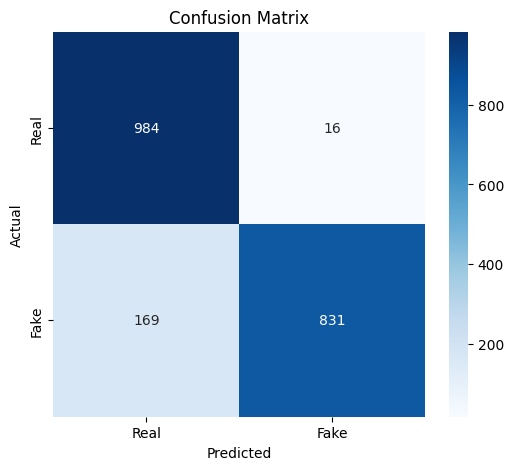

In [108]:
# 🔹 5. 최종 이진 판정 (확률 기준은 0.5 유지)
y_prob = predict_with_spectral_contrast(model,X_test, score=0.5)
y_pred = (y_prob >= 0.5).astype(int)
print("\n✅ Classification Report - TEST DATA")
print(classification_report(y_test, y_pred, target_names=['Real','Fake']))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.3f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real','Fake'], yticklabels=['Real','Fake'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Spectral contrast 최적화 기준 자동화 선별 함수 (실험 코드)

In [109]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

import os

# 1) 실제 오디오 파일들이 들어 있는 디렉토리 경로
test_audio_path = "test"   # 예시: 테스트 오디오가 들어 있는 폴더명

# 2) 해당 폴더에 있는 모든 .wav 파일 이름을 리스트로 가져오기
test_filenames = sorted([
    f for f in os.listdir(test_audio_path)
    if f.lower().endswith('.wav')
])



def run_experiment(model, X_test, y_test, test_filenames, test_audio_path,
                   prob_thresholds=[0.3, 0.4, 0.5, 0.6],
                   contrast_bounds=[(22.0, 26.0), (23.0, 26.5), (22.5, 27.0)]):

    results = []

    for prob_thresh in prob_thresholds:
        for contrast_low, contrast_high in contrast_bounds:
                    # 1. DNN 확률 예측
          y_prob = model.predict(X_test).flatten()

          # 2. 보정 대상 (확률 기준 이하)
          uncertain_idx = np.where(y_prob < prob_thresh)[0]

          # 3. Spectral Contrast 보정
          for idx in tqdm(uncertain_idx, desc=f"🔍 p<{prob_thresh}, c<{contrast_low} or >{contrast_high}"):
              file_path = os.path.join(test_audio_path, test_filenames[idx])
              try:
                  y, sr = librosa.load(file_path, sr=16000)
                  contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
                  high_contrast = np.mean(contrast[-2:, :])

                  # Fake로 보정 조건
                  if high_contrast < contrast_low or high_contrast > contrast_high:
                      y_prob[idx] = 1.0  # Fake로 강제 보정
              except Exception as e:
                  print(f"⚠️ Error: {file_path} - {e}")
          for a in prob_thresholds:
            # 4. 이진 결과
            y_pred = (y_prob >= a).astype(int)

            # 5. 지표 계산
            acc = accuracy_score(y_test, y_pred)
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

            # 6. 기록
            results.append({
                'a' : a,
                'prob_thresh': prob_thresh,
                'contrast_low': contrast_low,
                'contrast_high': contrast_high,
                'accuracy': acc,
                'precision': precision,
                'recall': recall,
                'f1': f1
            })

    return pd.DataFrame(results)

In [110]:
import numpy as np

# (이미 pad_to_4000 정의해 두셨다면 재정의할 필요 없습니다)
def pad_to_4000(x: np.ndarray) -> np.ndarray:
    curr_len, n_feat = x.shape  # 예: (2000,20)
    if curr_len >= 4000:
        return x[:4000, :]
    pad_width = 4000 - curr_len
    return np.concatenate([x, np.zeros((pad_width, n_feat), dtype=x.dtype)], axis=0)

def run_experiment(model, X_test, y_test, test_filenames, test_audio_path,
                   prob_thresholds, contrast_bounds):
    results = []
    
    # 1) 테스트 데이터 전체를 먼저 패딩해 둔다
    #    X_test.shape == (n_samples, 2000, 20) → X_test_padded.shape == (n_samples, 4000, 20)
    X_test_padded = np.array([pad_to_4000(x) for x in X_test])
    
    for prob_thresh in prob_thresholds:
        for contrast_low, contrast_high in contrast_bounds:
            # 2) DNN 예측: 반드시 X_test_padded를 넣는다
            y_prob = model.predict(X_test_padded).flatten()  # (n_samples,)
            
            # 3) DNN 확률 기반 보정 대상 인덱스 구하기
            uncertain_idx = np.where(y_prob < prob_thresh)[0]
            
            # (여기에 Spectral Contrast 보정 로직을 넣되, 역시 X_test_padded 사용)
            # 예를 들어:
            if len(uncertain_idx) > 0:
                sub_X = X_test_padded[uncertain_idx]
                # spec_scores = apply_spectral_contrast(sub_X, low=contrast_low, high=contrast_high)
                # y_prob[uncertain_idx] = spec_scores
            
            # 4) 최종 이진 예측
            y_pred = (y_prob >= prob_thresh).astype(int)
            
            # 5) 평가 지표 계산 (예: precision, recall, f1 등)
            #    아래는 예시 – 실제로 원하는 metric을 추가하세요.
            from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_prob)
            
            results.append({
                'prob_thresh': prob_thresh,
                'contrast_low': contrast_low,
                'contrast_high': contrast_high,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'auc': auc
            })
    
    import pandas as pd
    return pd.DataFrame(results)


In [111]:
# 실험 설정 값
prob_thresholds = [0.32]
contrast_bounds = [(21,27),(20.5, 27.5)]

# 실행
result_df = run_experiment(model, X_test, y_test, test_filenames, test_audio_path,
                           prob_thresholds, contrast_bounds)

# 결과 출력 (F1-score 기준 정렬)
result_df_sorted = result_df.sort_values(by='f1', ascending=False).reset_index(drop=True)

from IPython.display import display
display(result_df_sorted)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


,prob_thresh,contrast_low,contrast_high,precision,recall,f1,auc
0,0.32,21.0,27.0,0.97219,0.839,0.900698,0.912454
1,0.32,20.5,27.5,0.97219,0.839,0.900698,0.912454


# 예측 결과 파일 작성

In [112]:
from sklearn.preprocessing import LabelEncoder

# 1. test 파일명 리스트 로딩
def get_test_filenames(label_path):
    filenames = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                filenames.append(parts[1])
    return filenames

# 2. LabelEncoder: Fake → 0, Real → 1
le = LabelEncoder()
le.fit(['Fake', 'Real']) # 반드시 이 순서로 지정해야 0=Fake, 1=Real

# 3. 파일 이름 로드
test_file_names = get_test_filenames(test_label_path)

# 4. 예측 확률 → 클래스 (0 또는 1) => 정규화 방식에 따라 정확도가 차이가 남.
y_pred_prob =predict_with_spectral_contrast(model,X_test, score=0.5)
# y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_pred_classes = (y_pred_prob <= 0.5).astype(int).flatten()  # 확률 → 0 or 1


# 5. 예측 결과 파일 작성
with open('./test_result.txt', 'w') as f:
    for i in range(len(y_pred_classes)):
        label_str = le.inverse_transform([y_pred_classes[i]])[0]  # 0 → Fake, 1 → Real
        f.write(f"{test_file_names[i]} {label_str}\n")

print("✅ test_result.txt 저장 완료 (Perl 평가용)")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
✅ test_result.txt 저장 완료 (Perl 평가용)


In [113]:
import os

def evaluate_with_python(pred_path: str, true_path: str):
    """
    Perl eval.pl과 동일하게,
    1) pred_path 파일의 각 줄에서 두 번째 토큰(인덱스1)을 꺼내,
    2) true_path 파일의 각 줄에서 다섯 번째 토큰(인덱스4)을 꺼내 비교,
    3) 전체 대비 맞춘 비율(Accuracy)과 맞춘 개수(hit), 총 개수(total)을 출력합니다.
    """
    # 1) 예측 파일 읽기
    with open(pred_path, 'r', encoding='utf-8') as f_pred:
        lines_pred = [line.strip() for line in f_pred if line.strip()]
    
    # 2) 정답 파일 읽기
    with open(true_path, 'r', encoding='utf-8') as f_true:
        lines_true = [line.strip() for line in f_true if line.strip()]
    
    # 3) 두 파일의 라인 수가 동일해야 정상
    if len(lines_pred) != len(lines_true):
        print("Error: 예측 파일과 정답 파일의 라인 수가 다릅니다.")
        print(f"  예측({pred_path}) 라인 수: {len(lines_pred)}")
        print(f"  정답({true_path}) 라인 수: {len(lines_true)}")
        return
    
    total = len(lines_pred)
    hit = 0
    
    # 4) 한 줄씩 순회하면서 두 번째 토큰 vs 다섯 번째 토큰 비교
    for i, line_pred in enumerate(lines_pred):
        # 예: "somefile.wav Fake"
        parts_pred = line_pred.split()
        # 만약 토큰 개수가 2개 이상이어야 두 번째 토큰(parts_pred[1])에 접근 가능
        if len(parts_pred) < 2:
            print(f"Warning: 예측 파일 {i+1}번째 줄 토큰 개수 부족 → '{line_pred}'")
            continue
        predicted_label = parts_pred[1]
        
        # 정답 줄: 보통 다섯 번째 토큰이 TrueLabel
        # ex) "0 0 0 0 Real" 또는 "xxx yyy zzz www Real"
        line_true = lines_true[i]
        parts_true = line_true.split()
        if len(parts_true) < 5:
            print(f"Warning: 정답 파일 {i+1}번째 줄 토큰 개수 부족 → '{line_true}'")
            continue
        true_label = parts_true[4]
        
        if predicted_label == true_label:
            hit += 1
    
    # 5) 정확도 계산
    accuracy = hit / total * 100.0
    
    # 6) 결과 출력 (Perl 스크립트와 비슷한 포맷)
    print("============ Results Analysis ===========")
    print(f"Test : {os.path.basename(pred_path)}")
    print(f"True : {os.path.basename(true_path)}\n")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Hit: {hit}, Total: {total}")
    print("=========================================")


# 사용 예시
# 1) 위에 정의한 evaluate_with_python 함수가 이미 셀에 있다고 가정합니다.

# 2) 호출 시 경로를 파일명만 사용
test_pred_path = "test_result.txt"
test_true_path = "test_label.txt"

evaluate_with_python(test_pred_path, test_true_path)


evaluate_with_python(test_pred_path, test_true_path)


============ Results Analysis ===========
Test : test_result.txt
True : test_label.txt

Accuracy: 90.75%
Hit: 1815, Total: 2000
============ Results Analysis ===========
Test : test_result.txt
True : test_label.txt

Accuracy: 90.75%
Hit: 1815, Total: 2000
